# Прогнозирование оттока клиентов в телекомуникационной компании

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.
   
Описание услуг
    
Оператор предоставляет два основных типа услуг: 
  1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
  2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
    
Также доступны такие услуги:
  1. Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
  2. Выделенная линия технической поддержки (TechSupport);
  3. Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
  4. Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
  
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

   Цель проекта: научиться прогнозировать уход клиента

План проекта:
1. Загрузка данных, ознакомление с данными
- describe(), info()
2. Объединение датасетов
- выделение целевого признака
3. Предобработка данных
- заполнение пропусков
- выделение новых признаков
- проверка на мультиколлинеарность
- удаление ненужных признаков
4. Разделение на выборки
- кодирование категориальных признаков
5. Обучение моделей и проверка лучшей
- Подбор гиперпараметров и обучение на кросс-валидации логистической регрессии, случайного леса, модели градиентного бустинга
- выбор лучшей
- проверка на тестовой выборке
6.  Выводы
- анализ важности признаков
- матрица ошибок.


# Загрузка и изучение данных.

In [1]:
!pip install phik


In [2]:
import pandas as pd
import numpy as np
import phik
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

In [3]:
link_contract = 'https://code.s3.yandex.net/datasets/contract_new.csv'
contract = pd.read_csv(link_contract,  sep=',')
contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [4]:
link_personal = 'https://code.s3.yandex.net/datasets/personal_new.csv'
personal = pd.read_csv(link_personal,  sep=',')
personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
link_internet = 'https://code.s3.yandex.net/datasets/internet_new.csv'
internet = pd.read_csv(link_internet,  sep=',')
internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [6]:
link_phone = 'https://code.s3.yandex.net/datasets/phone_new.csv'
phone = pd.read_csv(link_phone,  sep=',')
phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [7]:
def observe(data):
    print('Информация о датасете:', data.info())
    print('Явные дубликаты:', data.duplicated().sum())   
    print('Статистика:', data.describe()) 
    return
observe(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:        MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


In [8]:
observe(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:        SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [9]:
observe(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:         customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3566-VVORZ     Fiber optic             No           No   
freq             1            3096           3498         3088   

  

In [10]:
observe(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
Информация о датасете: None
Явные дубликаты: 0
Статистика:         customerID MultipleLines
count         6361          6361
unique        6361             2
top     2560-WBWXF            No
freq             1          3390


Мы ознакомились с 4мя датасетами. Не обнаружили пропусков в каждом из датасетов, не обнаружили дубликатов и каких-то аномалий в данных. В некоторых признаках определен 
неверно тип данных, например в таблице contract  в столбцах BeginDate, EndDate,TotalCharges  - изменим тип далее.


## Объединение датасетов

Объединим датасаты в один датафрейм по столбцу с уникльными значениями customerID.

In [11]:
df = contract \
    .merge(personal, how='left', on='customerID') \
    .merge(internet, how='left', on='customerID') \
    .merge(phone, how='left', on='customerID') 
# назначим customerID индексами
df = df.set_index('customerID')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

После объединения таблицы видим, что количество строк соответствует количеству контрактов. 1526 пропусков в признаках получилось из таблицы с доп услугами интернета, это означает, что 1526 клиентов не проводили себе интернет и пользуются только телефонией. 682 пропуска в признаке из таблицы  с доп услугой связи, это означает, что  682 клиента не подключали телефон и пользуются только интерентом.

In [13]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'duration']
cat_cols = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

### Выделим целевой признак.

Так как цель работы спрогнозировать уход клиента для выделения целевого признака воспользуемся колонкой с датой окончания контракта EndDate(если в столбце проставлена дата-значит пользователь ушел, если стоит значение 'No' - клиент продолжает пользоваться услугами).Создадим новый столбец, в котором  будут значения 0 - не ушел, 1 - ушел. 

In [14]:
df['activity'] =(df['EndDate'] != 'No').astype(int)
df.head(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,activity
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [15]:
# Переведем числовые данные в верный формат и найдем продолжительность пользования услугами в днях для каждого клиента
# Так как дата выгрузки 01-02-2020 заменим 'No' в столбце EndDate этой датой
df['EndDate'] = pd.to_datetime(df['EndDate'].replace(['No'], ['2020-02-01']), format='%Y-%m-%d')
df['BeginDate'] =  pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['duration'] = (df['EndDate'] - df['BeginDate']).dt.days
# заменим тип данных в столбце TotalCharges
#df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors ='coerce')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtecti

Таблицы объединили, новые столбцы создали, изменили типы данных, где было необходимо. Однако появились пропуски, тк клиенты не обязательно пользуются всеми услугами компании. Заменим их на новые значения 'no_internet' для пропус в услугах интернета и 'not_used' для пропусков в услуге для телефонов. Также мы видим пропуски в TotalCharges, где их не было. Далее расмотрим поближе.


In [17]:
# Рассмотрим пропуски в TotalCharges
df[df['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,activity,duration
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0


Всего 11 строк с NaN. По дате начала контракта видим, что пользователи стали клиентами компании в день выгрузки, поэтому вместо пропусков ставим 0, тк им еще не начислено ни одного платежа.

In [18]:
# заменяем пропуски связанные с неиспользованием интернета или телефона.
df['InternetService'] = df['InternetService'].fillna('not_used')
for column in('OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'):
    df[column] = df[column].fillna('No')
df['MultipleLines'] = df['MultipleLines'].fillna('not_used')


In [19]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)


Так как решается задача классификации и мы вывели новые признаки на основе дат, можно столбцы с датами удалить.

In [20]:
df = df.drop(['EndDate', 'BeginDate'], axis = 1) 

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null 

Теперь рассмотрим корреляцию признаков, проверим признаки на мультиколлинеарность.

In [22]:
cor = df.phik_matrix(['MonthlyCharges', 'TotalCharges', 'duration']).round(2)

<AxesSubplot:>

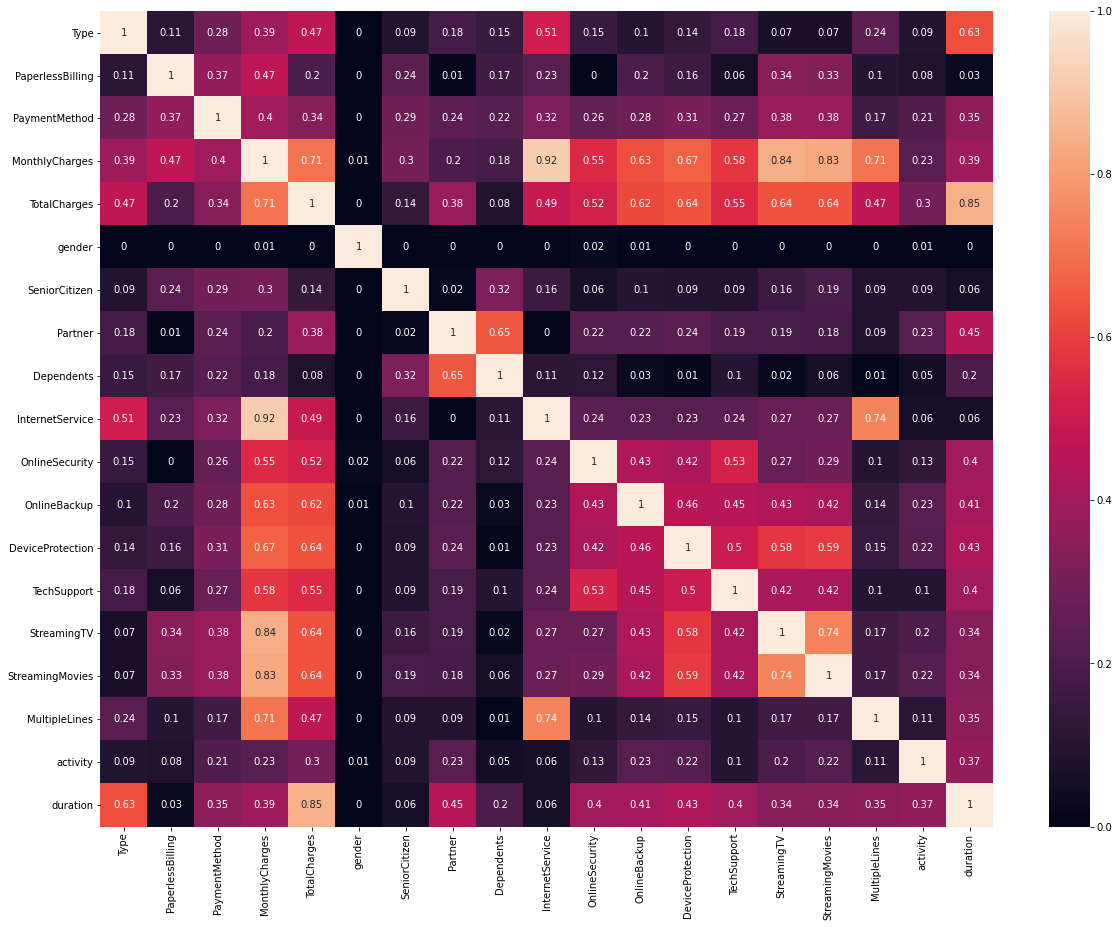

In [23]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(cor, annot = True)

По матрице корреляции мы видим, что есть мультиколлинеарность признаков, а именно значение TotalCharges связано с длительностью пользования услугами компании. Удалим признак TotalCharges.

In [24]:
df = df.drop(['TotalCharges'], axis = 1)

Также видим высокую корреляцию MonthlyCharges с признаками InternetService, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines

In [25]:
cor['MonthlyCharges'].sort_values(ascending=False)

MonthlyCharges      1.00
InternetService     0.92
StreamingTV         0.84
StreamingMovies     0.83
TotalCharges        0.71
MultipleLines       0.71
DeviceProtection    0.67
OnlineBackup        0.63
TechSupport         0.58
OnlineSecurity      0.55
PaperlessBilling    0.47
PaymentMethod       0.40
Type                0.39
duration            0.39
SeniorCitizen       0.30
activity            0.23
Partner             0.20
Dependents          0.18
gender              0.01
Name: MonthlyCharges, dtype: float64

Я думаю, что мы можем удалить эти признаки, тк величина платы уже отражает наличие доп услуг(чем больше цена, тем больше услуг подключено).


In [26]:
df = df.drop(['InternetService', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'MultipleLines'], axis = 1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   gender            7043 non-null   object 
 5   SeniorCitizen     7043 non-null   int64  
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  activity          7043 non-null   int64  
 11  duration          7043 non-null   int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 715.3+ KB
